# 1 dimensional laws

In [3]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf

2022-02-25 14:38:53.374861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 14:38:53.374885: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Wolfram's 256 Rules

These are all cellular automaton rules for a 1-d array with only neares neighbour interaction. There are therefore only three cells (L,C,R) determining the outcome of one cell (C). This gives 2^3=8 possible combinations that can give rise to an outcome of 2 possibilities. Thus there are 2^8=256 possible rules. 

The following function generates each of these rules.
 
Input:  
num = number of rule  
inp = string of input bits   
t = number of timesteps calculated  

Output: an array of arrays each for one timestep beginning with the input array. 

The boudary conditions are periodic
        

In [4]:
def CellularAutomata(num,inp,t):
    bnum = np.flip(np.fromiter(np.binary_repr(num,width=8),dtype=int))
    out = [np.fromiter(inp,dtype=int)]
    lin = len(inp)
    currinp = inp
    for n in range(t):
        outnow = []
        for i in range(len(inp)):
            outnow = np.append(outnow,bnum[int(str(currinp[(i-1)%lin])+str(currinp[(i)%lin])+str(currinp[(i+1)%lin]),2)])

        currinp =''.join([str(int(elem)) for elem in outnow])
        out = np.append(out,[outnow],axis=0)
    return(out)


## Generating Data

In [6]:
N=10000 #batch size
L=3 #Length of box
rule= 170
time = 1

x_train=[]
y_train=[]


for i in range(N):
    #x=[0,0,0]
    #x[np.random.randint(0,3)]=1
    x=np.random.randint(0,2,L)
    x_train.append(np.copy(x))
    y_train.append(np.copy(CellularAutomata(rule,''.join([str(int(elem)) for elem in x]),time)[time]))
    #print(''.join([str(int(elem)) for elem in x]),CellularAutomata(rule,''.join([str(int(elem)) for elem in x]),time)[time,0])

#for i in range(20):
 #   print(x_train[i],y_train[i])
    
x_train = np.array(x_train).reshape(N,L,1)
y_train = np.array(y_train).reshape(N,L)
print(x_train.shape,y_train.shape)

(10000, 3, 1) (10000, 3)


## Models
useful resource for understanding what is going on:  
Padding https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/  
Guide to 2d conv layers https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/  
Guide to 1d conv layers https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/  
shapes, dimensions and units https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc  


### Dense layers

### 1-D Convolutional layer

In [7]:
#add periodic padding
def periodic_padding(imbatch, padding=1):
    '''
    Create a periodic padding (wrap) around an image batch, to emulate 
    periodic boundary conditions. Padding occurs along the middle two axes
    '''
    pad_u = imbatch[:, -padding:, :]
    pad_b = imbatch[:, :padding, :]

    partial_image = tf.concat([pad_u, imbatch, pad_b], axis=1)

#    pad_l = partial_image[..., -padding:, :]
 #   pad_r = partial_image[..., :padding, :]

 #   padded_imbatch = tf.concat([pad_l, partial_image, pad_r], axis=2)
          
    
    return padded_imbatch

class Wraparound2D(tf.keras.layers.Layer):
    """
    Apply periodic boundary conditions on an image by padding 
    along the axes
    padding : int or tuple, the amount to wrap around    
    """

    def __init__(self, padding=2, **kwargs):
        super(Wraparound2D, self).__init__()
        self.padding = padding

In [8]:
## (Approx) Model from Paper https://arxiv.org/pdf/1809.02942.pdf
nhood = 1
shape = (1,L)
wspan,hspan = shape
diameter = 3
layer_dims=[2^L,20]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer((hspan,1))) 
model.add(Wraparound2D(padding=nhood)) #adding periodic padding extending by nhood
model.add(tf.keras.layers.Conv1D(
        layer_dims[0],
        diameter,
        activation='softmax', 
        input_shape=(hspan,1),
        padding='same',
        kernel_initializer=tf.keras.initializers.he_normal(),
        bias_initializer=tf.keras.initializers.he_normal()                                
        )      
    )
for i in range(1,len(layer_dims)):      
    model.add(tf.keras.layers.Conv1D(layer_dims[i],1, activation='sigmoid', input_shape=(hspan,1),padding='same'))
    #model.add(tf.keras.layers.Dense(layer_dims[i], activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(L,activation="softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wraparound2d (Wraparound2D)  (None, 3, 1)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 1)              4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 20)             40        
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 183       
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________


2022-02-25 14:39:17.430494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-25 14:39:17.430525: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-25 14:39:17.430550: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (manu-ThinkPad-T460s): /proc/driver/nvidia/version does not exist
2022-02-25 14:39:17.430854: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Execute learning

2022-02-25 14:30:01.931218: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


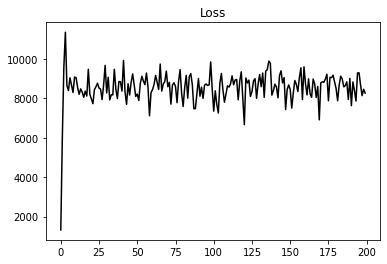

In [10]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
#loss_fn = tf.keras.metrics.BinaryAccuracy()
#loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="auto",name="sparse_categorical_crossentropy")


predictions = model(x_train).numpy()

loss_fn(y_train, predictions).numpy()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=loss_fn,
              metrics=[tf.keras.metrics.BinaryAccuracy()]
                #metrics= [tf.keras.losses.CategoricalCrossentropy()]
             )
train_history = model.fit(x=x_train, y=y_train, epochs=200,verbose=0)
plt.title("Loss")
plt.plot(train_history.history['loss'], 'k')